**MULTI TASKING**






In [ ]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk
import re
import time
import datetime
import random
import pickle
import torch.nn.functional as F

import torch.nn as nn
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification, AdamW, AutoConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

colab = True
if(colab):
  from google.colab import drive
  from google.colab import files

  drive.mount('/content/drive')


class MultiTaskingModel(nn.Module):
    def __init__(self, num_labels):
        super(MultiTaskingModel, self).__init__()
        self.num_labels = num_labels

        # self.bert = AutoModel.from_pretrained('dbmdz/bert-base-turkish-uncased')
        self.bert = AutoModel.from_pretrained('ytu-ce-cosmos/turkish-base-bert-uncased')
        self.config = self.bert.config

        self.dropout = nn.Dropout(0.5)

        self.classifier_sentiment = nn.Linear(self.config.hidden_size, self.num_labels['sentiment'])
        self.classifier_topic = nn.Linear(self.config.hidden_size, self.num_labels['topic'])

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None,
                head_mask=None, inputs_embeds=None, labels=None, task_name=None, return_dict=True):

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            return_dict=return_dict,
        )

        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)

        logits = None
        loss = None

        if task_name == 'sentiment':
            logits = self.classifier_sentiment(pooled_output)
        elif task_name == 'topic':
            logits = self.classifier_topic(pooled_output)

        if labels is not None:
            if task_name == 'sentiment':
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels[task_name]), labels.view(-1))
            if task_name == 'topic':
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels[task_name]), labels.view(-1))




        if not return_dict:
            output = (logits,) + outputs[2:]  # Burada outputs'ın kalan kısmını döndürmek istiyorsanız.
            return ((loss,) + output) if loss is not None else output

        return {
            'loss': loss,
            'logits': logits,
            'hidden_states': outputs.hidden_states,
            'attentions': outputs.attentions
        }



def plot_sentence_embeddings_length(text_list, tokenizer): # reference:
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.hist(tokenized_texts_len, bins=40)
    ax.set_xlabel("Length of Comment Embeddings")
    ax.set_ylabel("Number of Comments")
    plt.title("Length of Embeddings")
    plt.show()

def clean_text(text):

    unwanted_pattern = r'[!.\n,:“”,?@#"]'
    regex = re.compile(unwanted_pattern)
    cleaned_text = regex.sub(" ", text)

    return cleaned_text

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



print(torch.cuda.device_count())
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


if(colab):
  df_train=pd.read_csv("/content/drive/MyDrive/SonData.csv")
else :
  df_train=pd.read_csv("SonData.csv")



sampled_data = pd.DataFrame(columns=df_train.columns)

counter = 0
for index, row in df_train.iterrows():

    if (row["siniflandirma"].strip() == "siyaset" and row["sentiment"].strip() == "negatif" ):
        counter += 1
        if(counter % 2) :
            df_train = df_train.drop(index)

for index, row in df_train.iterrows():
    if (row["siniflandirma"].strip() == "siyaset" ):
        counter += 1
        if(counter % 2) :
            df_train = df_train.drop(index)


# change string classes to int
df_train['siniflandirma'] = df_train.loc[:, 'siniflandirma'].map(lambda x: x.strip()).map({
                                                                                        'siyaset': 0,
                                                                                        'saglik': 1,
                                                                                        'kultur': 2,
                                                                                        'ekonomi': 3,
                                                                                        'dunya': 4,
                                                                                        'teknoloji': 5,
                                                                                        'spor': 6
})

# change string classes to int
df_train['sentiment'] = df_train.loc[:, 'sentiment'].map({'negatif' : 0, 'pozitif' : 1 })

df_train['new_text'] = df_train['tweet'].astype(str).apply(clean_text)
df_train['new_text'] = df_train['new_text'].str.replace("[\d]", "")
df_train['new_text'] = df_train['new_text'].str.lower()

nltk.download('stopwords')
ineffective = stopwords.words('turkish')
df_train['new_text'] = df_train['new_text'].apply(lambda x: " ".join(x for x in x.split() if x not in ineffective))

comments = df_train.new_text.values
sentiment = df_train.sentiment.values
classification = df_train.siniflandirma.values

#Load BERT Turkish tokenizer
# tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-uncased")
tokenizer= AutoTokenizer.from_pretrained('ytu-ce-cosmos/turkish-base-bert-uncased')


# plot_sentence_embeddings_length(comments,tokenizer)

comments_list = comments.tolist()
indices=tokenizer.batch_encode_plus(comments_list,max_length=42,add_special_tokens=True, return_attention_mask=True,padding=True,truncation=True)

input_ids=indices["input_ids"]
attention_masks=indices["attention_mask"]

print(df_train["sentiment"].value_counts())
print(df_train["siniflandirma"].value_counts())
print("----")


In [ ]:


# Split the data into train and test-validation sets
train_input_ids, temp_input_ids, train_attention_masks, temp_attention_masks, train_labels_classification, temp_labels_classification, train_labels_sentiment, temp_labels_sentiment = train_test_split(
    input_ids, attention_masks, classification, sentiment, test_size=0.3, random_state=42
)

# Split the test-validation set into validation and test sets
validation_input_ids, test_input_ids, validation_attention_masks, test_attention_masks, validation_labels_classification, test_labels_classification, validation_labels_sentiment, test_labels_sentiment = train_test_split(
    temp_input_ids, temp_attention_masks, temp_labels_classification, temp_labels_sentiment, test_size=0.4, random_state=42
)


print("Train data len for classification: ",len(train_labels_classification))
print("Validation data len for classification", len(validation_labels_classification))
print("Test data len for classification", len(test_labels_classification))


Train data len for classification:  1201
Validation data len for classification 309
Test data len for classification 207


In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


# Use DataLoader for train, validation, and test sets
batch_size = 16
lr = 2e-5
epochs = 8

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_input_ids)
validation_inputs = torch.tensor(validation_input_ids)
test_inputs = torch.tensor(test_input_ids)


train_labels = torch.tensor(train_labels_classification, dtype=torch.long)
validation_labels = torch.tensor(validation_labels_classification, dtype=torch.long)
test_labels_classification = torch.tensor(test_labels_classification, dtype=torch.long)

train_labels_sentiment = torch.tensor(train_labels_sentiment, dtype=torch.long)
validation_labels_sentiment = torch.tensor(validation_labels_sentiment, dtype=torch.long)
test_labels_sentiment = torch.tensor(test_labels_sentiment, dtype=torch.long)


train_masks = torch.tensor(train_attention_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_attention_masks, dtype=torch.long)
test_masks = torch.tensor(test_attention_masks, dtype=torch.long)


# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels, train_labels_sentiment)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_labels_sentiment)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Create the DataLoader for test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels_classification, test_labels_sentiment)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)



In [ ]:


num_labels = {
    'sentiment': 2,
    'topic': 7
}

model = MultiTaskingModel(num_labels)

if torch.cuda.is_available():
    model.cuda()

optimizer = AdamW(model.parameters(),
                lr = lr , # args.learning_rate - default is 5e-5
                betas=[0.9,0.999],
                eps = 1e-6 # args.adam_epsilon  - default is 1e-8.
                )

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)




======== Epoch 1 / 8 ========
Training...
  Batch    30  of     76.    Elapsed: 0:00:07.
  Batch    60  of     76.    Elapsed: 0:00:13.

  Average training loss: 2.59
  Training epoch took: 0:00:16

Running Validation...
  Topic Accuracy: 0.29
  Sentiment Accuracy: 0.69
  Validation took: 0:00:01

======== Epoch 2 / 8 ========
Training...
  Batch    30  of     76.    Elapsed: 0:00:07.
  Batch    60  of     76.    Elapsed: 0:00:13.

  Average training loss: 2.48
  Training epoch took: 0:00:17

Running Validation...
  Topic Accuracy: 0.41
  Sentiment Accuracy: 0.70
  Validation took: 0:00:01

======== Epoch 3 / 8 ========
Training...
  Batch    30  of     76.    Elapsed: 0:00:07.
  Batch    60  of     76.    Elapsed: 0:00:13.

  Average training loss: 2.21
  Training epoch took: 0:00:17

Running Validation...
  Topic Accuracy: 0.51
  Sentiment Accuracy: 0.77
  Validation took: 0:00:01

======== Epoch 4 / 8 ========
Training...
  Batch    30  of     76.    Elapsed: 0:00:07.
  Batch    60

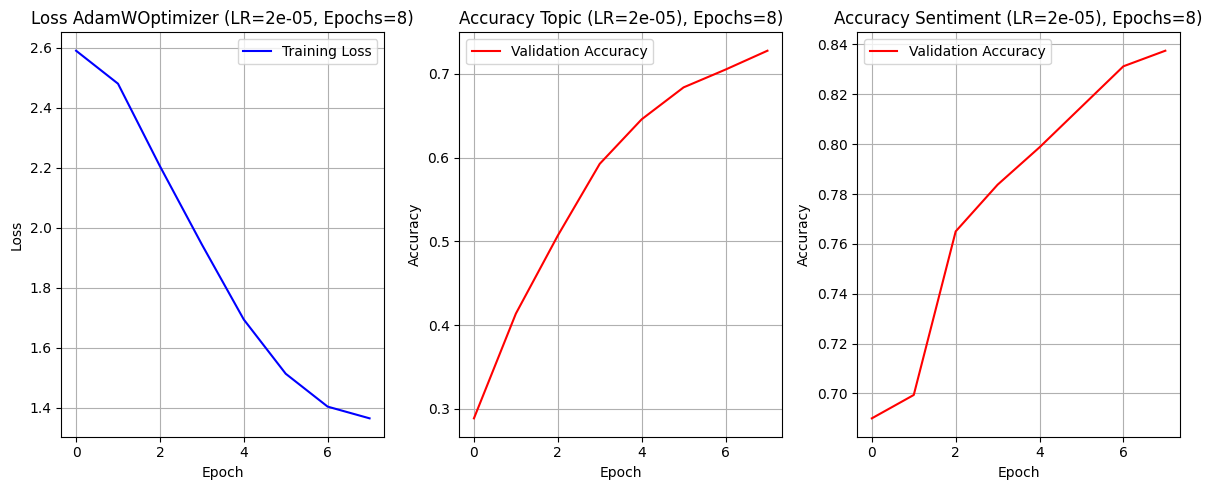

In [ ]:
# Store the average loss after each epoch so we can plot them.
loss_values = []
acc_values = []
acc_values_sentiment = []

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 30 batches.
        if step % 30 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        topic_labels = batch[2].to(device)
        sentiment_labels = batch[3].to(device)



        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification

        # b_labels = torch.cat([b_labels, b_labels], dim=0)  # Herhangi bir boyut belirleme amaçlı çoğaltma
        # b_labels = b_labels.to(torch.float32)

        outputs = model(b_input_ids,
                    attention_mask=b_input_mask,
                    task_name = 'topic',
                    labels=topic_labels)

        loss = outputs['loss']

        # TYPE LOSs: <class 'torch.Tensor'>
        # TYPE LOSs.item(): <class 'float'>

        # print(loss.item())
        # print(type(loss))
        sentiment_outputs = model(b_input_ids,
                    attention_mask=b_input_mask,
                    task_name = 'sentiment',
                    labels=sentiment_labels)

        sentiment_loss = sentiment_outputs['loss']


        both_of_losses = loss + sentiment_loss
        both_of_losses.backward()

        total_loss += both_of_losses.item()


        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(float(avg_train_loss))

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy, eval_accuracy_sentiment = 0, 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels, sentiment_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            task_name = 'topic')

            outputs_sentiment = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            task_name = 'sentiment')

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs['logits']
        logits_sentiment = outputs_sentiment['logits']


        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        logits_sentiment = logits_sentiment.detach().cpu().numpy()

        label_ids = b_labels.to('cpu').numpy()
        label_ids_sentiment = sentiment_labels.to('cpu').numpy()


        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        tmp_eval_accuracy_sentiment = flat_accuracy(logits_sentiment, label_ids_sentiment)


        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        eval_accuracy_sentiment += tmp_eval_accuracy_sentiment


        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Topic Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Sentiment Accuracy: {0:.2f}".format(eval_accuracy_sentiment/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    acc_values.append(eval_accuracy/nb_eval_steps)
    acc_values_sentiment.append(eval_accuracy_sentiment/nb_eval_steps)





print("")
print("Training complete!")

pickle.dump(model, open(f'/content/drive/MyDrive/KolektifHw4/MultiTasking/Model/base_bert_uncased_multi_task_model_bs{batch_size}_e{epochs}_lr{lr}.pkl', 'wb'))

# Sonuçları görselleştirme
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)

plt.plot(loss_values, 'b-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.title(f'Loss AdamWOptimizer (LR={lr}, Epochs={epochs})')
plt.legend()

# Accuracy değerlerini görselleştirme
plt.subplot(1, 3, 2)
plt.plot(acc_values, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy Topic (LR={lr}), Epochs={epochs})')
plt.legend()
plt.grid(True)

# Accuracy değerlerini görselleştirme
plt.subplot(1, 3, 3)
plt.plot(acc_values_sentiment, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy Sentiment (LR={lr}), Epochs={epochs})')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/KolektifHw4/MultiTasking/Pic/base_bert_uncased_model_Epochs={epochs},LR={lr},bs{batch_size}.png')

plt.show(block=False)

** MODEL TESTING **

In [ ]:
test_accuracy_topic, test_accuracy_sentiment = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

test_acc_values_topic = []
test_acc_values_sentiment = []

# Evaluate data for one epoch
for batch in test_dataloader:

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, sentiment_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        task_name = 'topic')

        outputs_sentiment = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        task_name = 'sentiment')

    # Get the "logits" output by the model. The "logits" are the output
    # values prior to applying an activation function like the softmax.
    logits = outputs['logits']
    logits_sentiment = outputs_sentiment['logits']


    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    logits_sentiment = logits_sentiment.detach().cpu().numpy()

    label_ids = b_labels.to('cpu').numpy()
    label_ids_sentiment = sentiment_labels.to('cpu').numpy()


    # Calculate the accuracy for this batch of test sentences.
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    tmp_eval_accuracy_sentiment = flat_accuracy(logits_sentiment, label_ids_sentiment)


    # Accumulate the total accuracy.
    test_accuracy_topic += tmp_eval_accuracy
    test_accuracy_sentiment += tmp_eval_accuracy_sentiment


    # Track the number of batches
    nb_eval_steps += 1

# Report the final accuracy for this validation run.
print("  Topic Accuracy: {0:.2f}".format(test_accuracy_topic/nb_eval_steps))
print("  Sentiment Accuracy: {0:.2f}".format(test_accuracy_sentiment/nb_eval_steps))
print("  Validation took: {:}".format(format_time(time.time() - t0)))
test_acc_values_topic.append(test_accuracy_topic/nb_eval_steps)
test_acc_values_sentiment.append(test_accuracy_sentiment/nb_eval_steps)



  Topic Accuracy: 0.75
  Sentiment Accuracy: 0.83
  Validation took: 0:00:55
